<font size=7 face="courier">Experiment Source Code

This is the code used to create the diagrams in the notebook, `Experiment_Introduction.ipynb`.

# Set Up Notebook

import stuff

In [1]:
!pip install powerlaw

!pip install smart_open
!pip install awswrangler
!pip install deprecated
!pip install nptyping

Import Packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import braingeneers
from braingeneers.analysis.analysis import SpikeData, read_phy_files
import braingeneers.data.datasets_electrophysiology as ephys
import scipy.io as sio
import scipy
from scipy.ndimage import gaussian_filter1d
import glob
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import random
import matplotlib.patches as mpatches

Load Data

In [8]:
braingeneers.set_default_endpoint("./data")
files = glob.glob('./data/ephys/2022-04-28-e-/derived/kilosort2/*')
print('Loading', files[0])
sd = read_phy_files(files[0])
metadata = ephys.load_metadata('2022-04-28-e-')

Loading ./data/ephys/2022-04-28-e-/derived/kilosort2/Trace_20220428_15_52_47_chip11350_curated.zip


Get 2D layout of all electrodes

In [10]:
electrode_mapping = pd.DataFrame( metadata['ephys_experiments']['Trace_20220428_15_52_47_chip11350']['mapping'],
                                  columns=['channel','electrode','x','y'] )

# <font color="blue">electrode_layout</font> 

plots the placement of all the recording electrodes

In [16]:
def electrodeLayout():
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values

    plt.scatter(x,y,s=2)
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

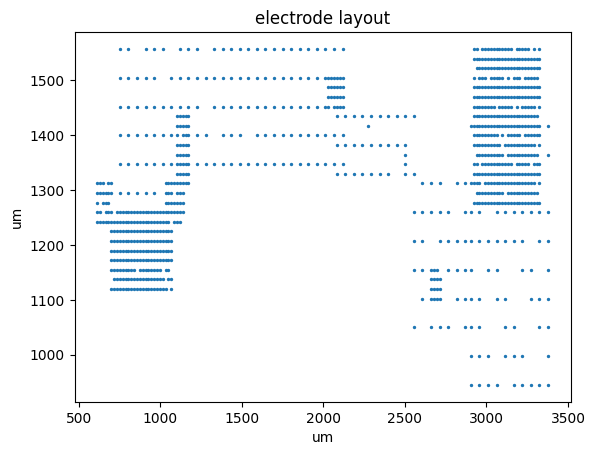

In [17]:
electrodeLayout()

# <font color="blue">neuronLayout</font> 

Plots the putative neural units found from spike sorting

In [18]:
def neuronLayout():
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values

    plt.scatter(x,y,s=2)

    neuron_x = []
    neuron_y = []
    neuron_amp = []
    for neuron in sd.neuron_data[0].values():
    #     print("x,y:",neuron['position'])
        neuron_x.append(neuron['position'][0])

        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

    # 
    plt.scatter(neuron_x,neuron_y,s=neuron_amp,c='r')


    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

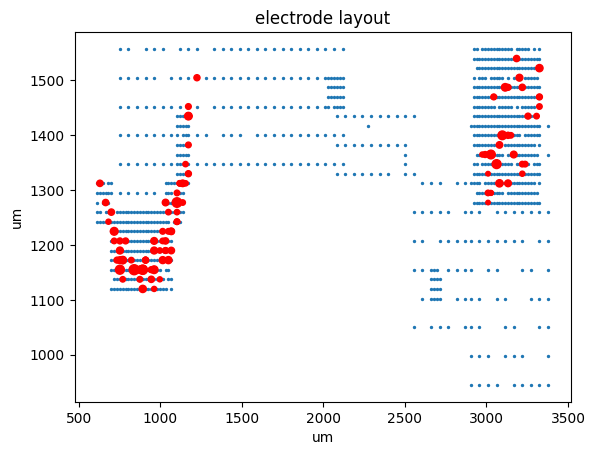

In [19]:
neuronLayout()

# <font color="blue">sttcLayout

Show which neurons are connected via spike time tiling

In [21]:
def sttcLayout( threshold ):
    # Lets bring back our graph, and overlay these as connectivity lines

    sttc = sd.spike_time_tilings()
    # electrodes
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values
    neuron_x = []
    neuron_y = []
    neuron_amp = []
    for neuron in sd.neuron_data[0].values():
        #     print("x,y:",neuron['position'])
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    plt.scatter(x,y,s=2)
    # Neurons
    plt.scatter(neuron_x,neuron_y,s=neuron_amp,c='r')

    # Now lines for each neuron if above threshhold
    for i in range(sttc.shape[0]):
        for j in range(sttc.shape[1]):

            # Only need to do upper triangle since sttc' = sttc
            if i<=j: continue

            if sttc[i,j] < threshold : continue

            #Position of neuron i
            ix,iy = sd.neuron_data[0][i]['position']
            jx,jy = sd.neuron_data[0][j]['position']

            # Plot line between the points, linewidth is the sttc
            plt.plot([ix,jx],[iy,jy], linewidth=sttc[i,j],c='k')

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    
    

    plt.subplot(1, 2, 2)
    sttc[sttc<threshold ] = 0
    plt.imshow(sttc,vmin=0,vmax=1)
    plt.colorbar()
    plt.title("Spike Time Tiling")
    plt.show()

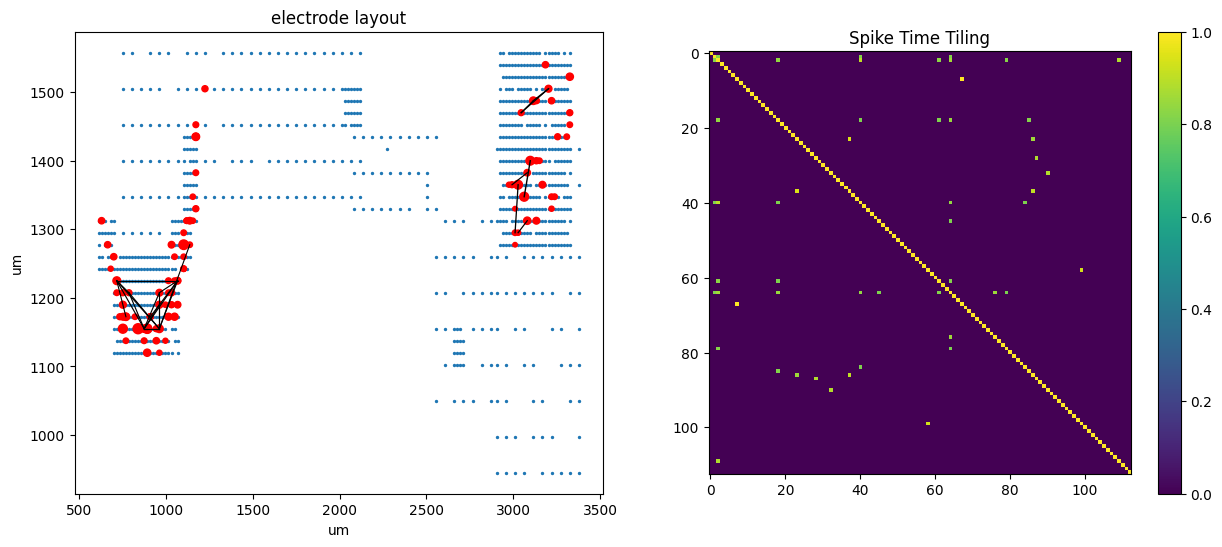

In [ ]:
sttcLayout(.8)

# <font color="blue">Latency Plots

Displays two plots. The left plot shows which two points the latencies are being calculated between. The right plot is a histogram of all the latencies between the points.


In [23]:
def latencyPlots(neuron1, neuron2):
    
    # Create plot of neural units with selected neurons for latency calculation in green
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    
    x = electrode_mapping.x.values
    y = electrode_mapping.y.values
    plt.scatter(x,y,s=2)

    neuron_x = []
    neuron_y = []
    neuron_amp = []
    for neuron in sd.neuron_data[0].values():
        print("x,y:",neuron['position'])
        neuron_x.append(neuron['position'][0])

        neuron_y.append(neuron['position'][1])
        neuron_amp.append(np.mean(neuron['amplitudes']))

    plt.scatter(neuron_x,neuron_y,s=neuron_amp,c='r')
    plt.scatter(neuron_x,neuron_y,s=neuron_amp,c='r')

    plt.scatter([neuron_x[neuron1]],[neuron_y[neuron1]],s=70,c='g')
    plt.scatter([neuron_x[neuron2]],[neuron_y[neuron2]],s=70,c='g')

    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()
    
    # Plot Histogram of latencies
    plt.subplot(1, 2, 2)
    lates_n1 = sd.latencies_to_index(neuron1)
    lates_raw = lates_n1[neuron2]
    lates =  list(filter(lambda x: x < 10 and x > -10, lates_raw ))
    plt.hist(lates,bins=8)
    plt.xlim([-25,25])
    print("Mean Latency: ", np.mean(lates) )
    print("Number of Latencies: ", len(lates))
    plt.show()
    
    

# <font color="blue"> deltaLayout

Creates a hypothetical electrode grid for a delta connectoid

In [24]:
def deltaLayout():
    random.seed(0)
    x = [int(random.gauss(1000,200)) for i in range(400)]
    y = [int(random.gauss(1900,200)) for i in range(400)]
    x = x + [int(random.gauss(2500,200)) for i in range(400)]
    y = y + [int(random.gauss(1000,200)) for i in range(400)]
    x = x + [int(random.gauss(1000,200)) for i in range(400)]
    y = y + [int(random.gauss(700,200)) for i in range(400)]

    plt.scatter(x,y,s=2)
    plt.xlabel('um')
    plt.ylabel('um')
    plt.title("electrode layout")
    plt.show()

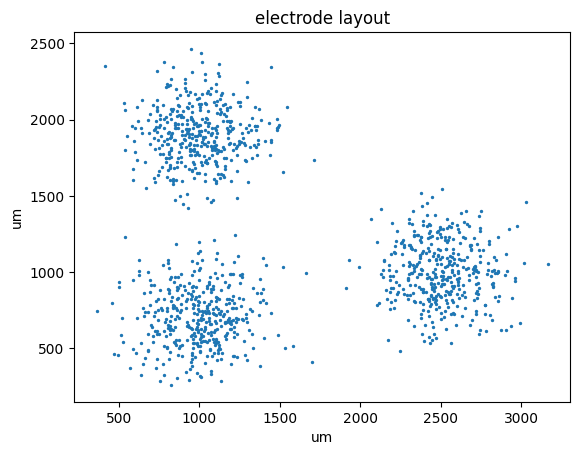

In [25]:
deltaLayout()

x,y: (1050.0, 1260.0)
x,y: (962.5, 1207.5)
x,y: (875.0, 1155.0)
x,y: (945.0, 1155.0)
x,y: (752.5, 1172.5)
x,y: (3132.5, 1312.5)
x,y: (3220.0, 1487.5)
x,y: (3097.5, 1400.0)
x,y: (875.0, 1137.5)
x,y: (962.5, 1120.0)
x,y: (3325.0, 1522.5)
x,y: (630.0, 1312.5)
x,y: (1050.0, 1172.5)
x,y: (3325.0, 1452.5)
x,y: (735.0, 1172.5)
x,y: (945.0, 1137.5)
x,y: (1032.5, 1190.0)
x,y: (1015.0, 1225.0)
x,y: (717.5, 1225.0)
x,y: (3220.0, 1347.5)
x,y: (3167.5, 1365.0)
x,y: (752.5, 1190.0)
x,y: (840.0, 1155.0)
x,y: (3202.5, 1505.0)
x,y: (682.5, 1242.5)
x,y: (910.0, 1172.5)
x,y: (892.5, 1120.0)
x,y: (770.0, 1172.5)
x,y: (3080.0, 1312.5)
x,y: (1225.0, 1505.0)
x,y: (1032.5, 1190.0)
x,y: (3325.0, 1470.0)
x,y: (3080.0, 1382.5)
x,y: (665.0, 1277.5)
x,y: (3237.5, 1347.5)
x,y: (3185.0, 1540.0)
x,y: (3045.0, 1470.0)
x,y: (3115.0, 1487.5)
x,y: (997.5, 1137.5)
x,y: (1050.0, 1225.0)
x,y: (1067.5, 1225.0)
x,y: (770.0, 1137.5)
x,y: (1102.5, 1242.5)
x,y: (1102.5, 1242.5)
x,y: (3010.0, 1330.0)
x,y: (1137.5, 1277.5)
x,y: (1

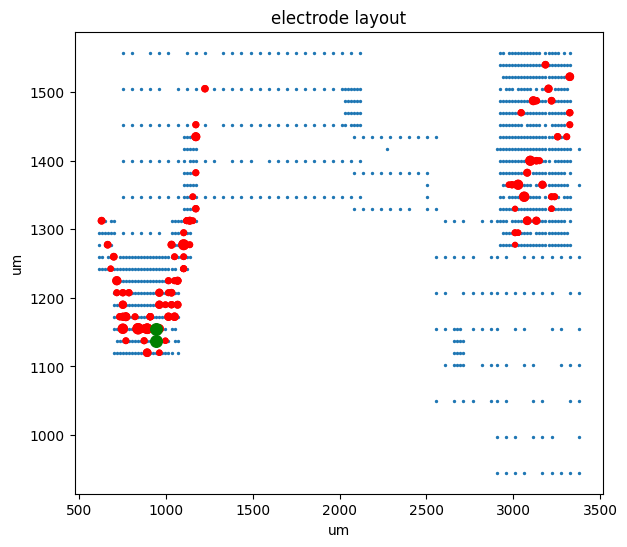

Mean Latency:  0.8173913043476363
Number of Latencies:  23


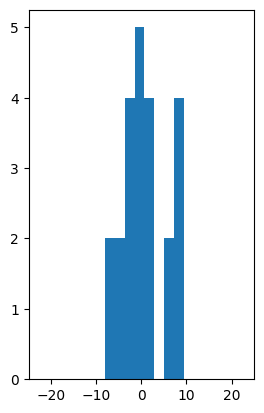

In [14]:
latencyPlots(3,15)

# Stim Basic Pulse

<font color="red"><b>Warning:</b> This code gets very messy. I do not reccomend reading it. You do not need to know it for the HW.

## <font color="gray">Helper Code

Get time and signal

In [15]:
def getTimeSignal(seconds, num_neurons=1):
    s_to_fs = 20000 
    return np.arange(0,seconds*s_to_fs)/s_to_fs , np.zeros((seconds* s_to_fs, num_neurons))

create square wave

In [16]:
def squareWave( signal, time_s, phase_us=200, amp_mV=150):
    s_to_fs = 20000   #ms_to_fs=20
    us_to_fs = .02
    
    time_fs  = time_s * s_to_fs
    phase_fs =  int(phase_us * us_to_fs)   # Previously used ms #phase_fs = phase_ms * ms_to_fs
    half_phase_fs = int(phase_fs/2)
    
    signal[ time_fs:time_fs+half_phase_fs] = amp_mV
    signal[ time_fs+half_phase_fs : time_fs+half_phase_fs*2] = -amp_mV
    return signal


## <font color="blue">stimBasicPulse

Plots an example of a basic stim pulse

In [17]:
def plotPulse():
    t,signal =  getTimeSignal(60)
    signal = squareWave( signal, time_s=1, phase_us=200, amp_mV=150 )

    plt.plot(t,signal)
    plt.xlim([.998,1.002])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.show()

# Stim Sequence Creater

<font color="red"><b>Warning:</b> This code gets very messy. I do not reccomend reading it. You do not need to know it for the HW.

## <font color="gray"> Helper Code

In [1]:
def insert_square_wave_advanced(sig,time,phase_length=20, amplitude=1):
    '''Deflects positively at *time* for 20 samples (1ms) then deflects negatively for 20 samples, 
    then returns to normal'''
    sig[time:time+phase_length] = amplitude
    sig[time+phase_length:time+phase_length*2] = -amplitude
    return sig

## <font color="blue"> Main Code Here

In [19]:

def create_stim_pulse_sequence(stim_list, freq_Hz=1, time_arr =None,max_time_s = 1):
    """
    Creates a stim pulse sequence, parallels the real code that will run on the Maxwell
    
    Params:
    stim_list - list of tuples indicating the commands to run
            ------------------------------------------------
            For 'stim' command:
            ('stim', [neuron inds], mv, us per phase)

            For 'delay'
            ('delay', frames_delay)
            
            For 'next'
            ('next', None)
            This command acts as a placeholder to move to the next timepoint in the time_arr or the next
            period triggered by the freq_Hz
            -------------------------------------------------
    freq_Hz - frequency to call the top stim_list in
            *Note* this takes priority over time_arr
    time_arr - array of time values that will be when the stimulations occur in order
    
    max_time_s - time in seconds to stimulate
    
    
    Returns:
    sig - np.array -- shape=(n_neurons, timesteps) of what the signal will look like
    t - np.array   -- shape=(timesteps) of time in seconds
    """
    
    # Since this is fake, only parallels the code on the device,
    # We have to make our own time
    # And simulate what the stimulation will look like
    
    # Conversion paramerters
    fs_ms = 20 # Good for converting frames to ms
    fs_us = .2
    
    # stim list
    seq = ('next',None)
    stim_list.append(seq)
    stim_list=stim_list*freq_Hz
    
    # Setup
    fs = 20000
    n_neurons = 3
    t = np.arange(0,fs*max_time_s)/fs
    sig = np.zeros(shape=(n_neurons,t.shape[0]))
    
    
    # This would be generated in *real time*
    if freq_Hz is not None:
        # Until the time is right to stimulation the sequence
        for time in t[::fs//freq_Hz]:
            time_frames = int(time*fs)
            
            
            if len(stim_list) == 0:
                return sig,t
            
            #Build the sequence
            command = None
            
            while (command != 'next'):
                command, *params = stim_list.pop(0) # Get first thing off list
                if command == 'stim':
                    neurons, amplitude, phase_length = params
                    phase_length = int(phase_length*fs_us)
                    
                    # Change signal for each neuron
                    for n in neurons:
                        sig[n,:] = insert_square_wave_advanced(sig[n,:],time_frames,phase_length, amplitude=amplitude)
                    time_frames += phase_length*2
                    
                if command == 'delay':
                    time_frames += fs_ms*params[0]
                    
                #double checking here
                if command == 'next':
                    break 
                    
        return sig,t

Example

In [26]:
stim_pattern = []
stim_pattern.append(('stim',[0],150,200))
stim_pattern.append(('delay',20))
stim_pattern.append(('stim',[1],200,20))
stim_pattern.append(('delay',250))
stim_pattern.append(('stim',[1],200,20))

signal,t = create_stim_pulse_sequence(stim_pattern, freq_Hz=1,time_arr=10,max_time_s=10)

create_stim_pulse_sequence(stim_pattern)

(array([[150., 150., 150., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 9.9985e-01, 9.9990e-01,
        9.9995e-01]))

In [32]:
def pulseLengthSampleLayout(neurons=[], freq = [], duration = []):
    stim_pattern = []
    freq = np.arange(2, 22, 2)
    duration = np.arange(41, 246+41, 41)
    for n in range(len(duration)):
        dur = duration[n]
        for i in range(len(freq)):
            output = []
            stim = create_stim_pulse_sequence([('stim', [0], 150, dur)], freq_Hz = freq[i], max_time_s = 1)[0]
            pause = (create_stim_pulse_sequence([('delay', 20000)], freq_Hz = 1, max_time_s = 1)[0][0])

            if np.shape(stim) == (20000,):
                output.append(stim)
            else:
                output.append(stim[0])
            output.append(pause)

            stim_pattern.append(np.concatenate(output))


## Plot Pulses

In [35]:
def plotStimPattern(signal,t):
    plt.plot(signal.T)
    plt.legend(['n0','n1','n2'])
    plt.xlabel('seconds')
    plt.ylabel('Voltage (mv)')
    plt.title("Stim Pattern over 10 Second")
    plt.show()

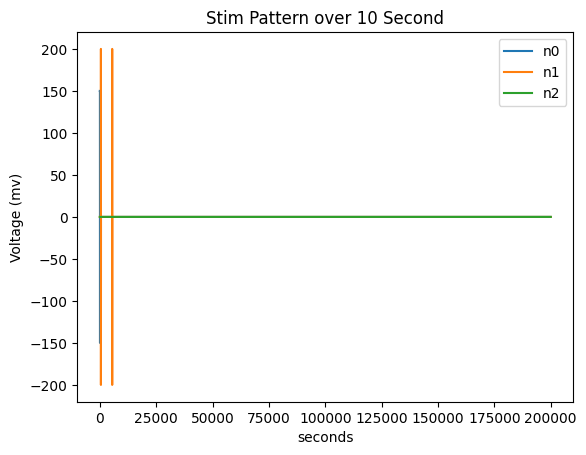

In [37]:
plotStimPattern(signal,t)

## Plot Individual Neurons

In [33]:
def plotIndividualPatterns(signal,t):
    names=["n0","n1","n2"]
    color=["#FF0000","#00FF00","#0000FF"]
    plt.figure(figsize=(16,4))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.plot(t,signal[i], color=color[i])
        plt.legend([f"n{i}"])
        plt.ylabel('Voltage (mv)')
        plt.xlabel('seconds')
        plt.show

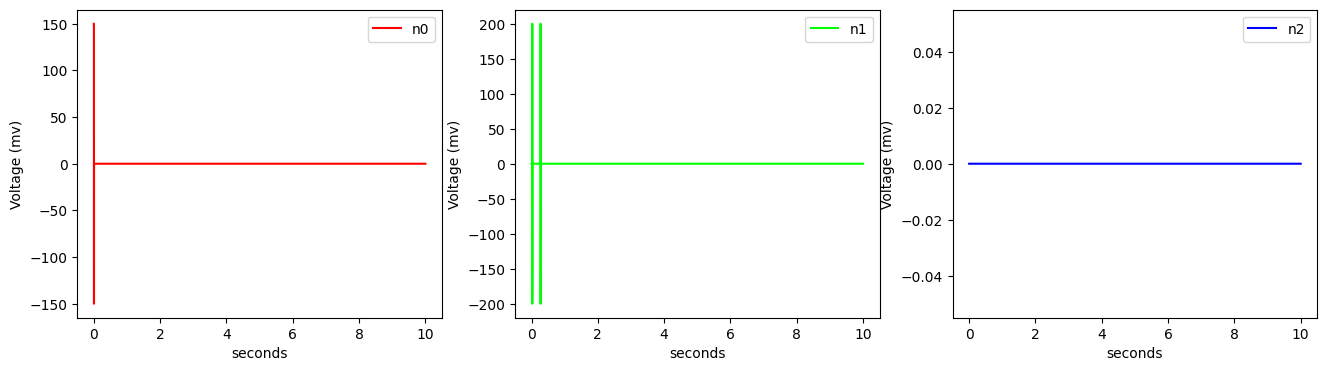

In [27]:
plotIndividualPatterns(signal,t)